In [21]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to the file or folder in Google Drive
file_path = '/content/drive/MyDrive/archive8'

# Check if the path exists and list its contents
if os.path.exists(file_path):
    print(f"Contents of the folder '{file_path}':")
    print(os.listdir(file_path))
else:
    print(f"The path '{file_path}' does not exist. Please check the file name or path.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Contents of the folder '/content/drive/MyDrive/archive8':
['archive8', '__MACOSX']


In [32]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

# Define dataset path
dataset_path = "drive/MyDrive/archive8/archive8/images/images"

# Data Generator for loading and preprocessing
datagen = ImageDataGenerator(rescale=1./255)

# Load dataset from directories
data = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),  # Resize images to 224x224 (VGG16 input size)
    batch_size=32,
    class_mode='categorical',  # Multi-class classification
    shuffle=True
)

# Extract data and labels
images, labels = [], []
for i in range(len(data)):
    x, y = data[i]
    images.append(x)
    labels.append(y)
    if len(images) * data.batch_size >= data.n:  # Stop when all data is loaded
        break

images = np.vstack(images)  # Combine into a single numpy array
labels = np.vstack(labels)


Found 900 images belonging to 10 classes.


In [33]:
# Load the pretrained VGG16 model (excluding the top classification layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Define the feature extractor model
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

# Extract features
features = feature_extractor.predict(images)
features = features.reshape(features.shape[0], -1)  # Flatten the features


29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step


In [34]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [35]:
# Convert one-hot encoded labels to class indices
labels = np.argmax(labels, axis=1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)


In [27]:
from sklearn.svm import SVC

# Initialize and train the SVM
svm = SVC(kernel='linear', probability=True)  # Use probability=True for ROC curves
svm.fit(X_train, y_train)


SVC(kernel='linear', probability=True)

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        22
           1       1.00      1.00      1.00        17
           2       0.95      0.95      0.95        20
           3       0.87      1.00      0.93        13
           4       0.96      1.00      0.98        23
           5       1.00      1.00      1.00        15
           6       1.00      1.00      1.00        18
           7       1.00      0.88      0.93        16
           8       1.00      0.89      0.94        18
           9       0.94      0.94      0.94        18

    accuracy                           0.97       180
   macro avg       0.97      0.97      0.97       180
weighted avg       0.97      0.97      0.97       180



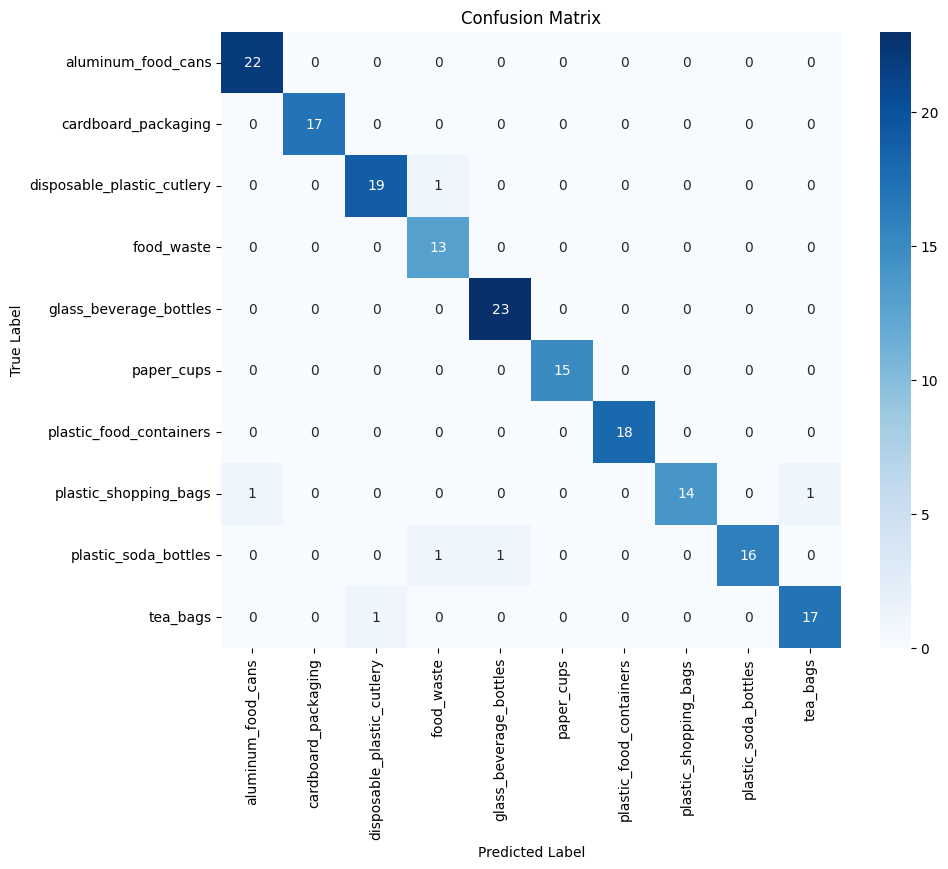

In [37]:
# Predict on the test set
y_pred = svm.predict(X_test)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=data.class_indices.keys(), yticklabels=data.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


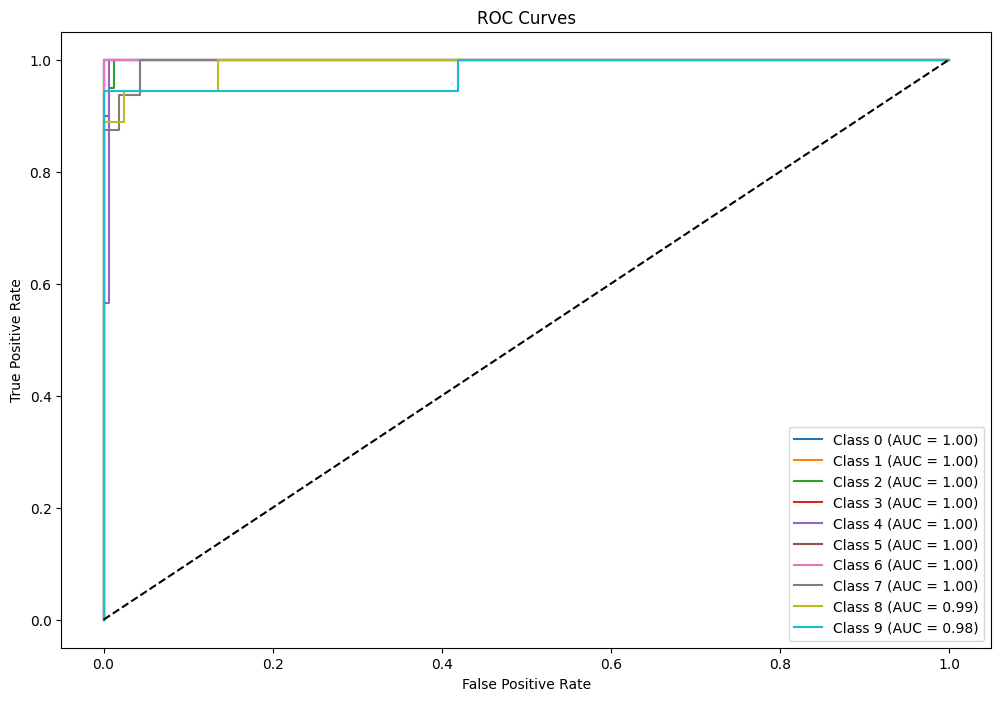

In [38]:
from sklearn.preprocessing import label_binarize

# Binarize labels for ROC curve (needed for multi-class classification)
y_test_binarized = label_binarize(y_test, classes=np.unique(labels))
y_pred_proba = svm.decision_function(X_test)

# Plot ROC curves for each class
plt.figure(figsize=(12, 8))
for i in range(y_test_binarized.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()
